<a href="https://colab.research.google.com/github/shinji-ohkubo/CfC/blob/main/stacking_ncp_with_other_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to stack NCP with other types of layers

In this tutorial we will stack an NCP with a convolutional head, similar to the architecture for the end-to-end driving in the paper.

We make two minor simplifications though:

1.   We won't train our model on the *driving-from-camera-images* dataset, but a 1D *collision avoidance from LIDAR signals* dataset intead. The reason is that the original dataset is quite large and takes a long time to train. Nonetheless, the taught concepts apply for image based data as well.
2.   We won't seperate the feature-maps of the last convolutional layer as it was done in the paper. The reason is that it doesn't teach any NCP related concepts and might be a bit confusing.



In [ ]:
# Install dependencies if they are not installed yet
!pip install -U seaborn ncps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 13 kB/s 
     |████████████████████████████████| 288 kB 42.6 MB/s 
     |████████████████████████████████| 44 kB 1.3 MB/s 
     |████████████████████████████████| 1.7 MB 38.3 MB/s 
     |████████████████████████████████| 5.9 MB 45.6 MB/s 
     |████████████████████████████████| 438 kB 57.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: fla

In [ ]:
import numpy as np
import os
from tensorflow import keras
import tensorflow as tf
from ncps.wirings import AutoNCP
from ncps.tf import LTC
import matplotlib.pyplot as plt
import seaborn as sns

## Preparing the dataset

The dataset we are using considers the task of maneuvering a mobile robot to avoid obstacles in its path.
Input data is obtained from a [Sick LMS 1xx laser rangefinder (LiDAR)](https://www.sick.com/ag/en/detection-and-ranging-solutions/2d-lidar-sensors/lms1xx/c/g91901) mounted on the robot. Output variable is the steering direction as a variable in the range [-1,+1], i.e., -1 corresponding to turning left, 0 going straight, and +1 to turning right.
Supervised training data was collected by manually steering the robot around the obstacles on 29 different tracks.

![collision_avoidance.png](https://github.com/mlech26l/icra_lds/raw/master/robot_small.png)

First, we will download the dataset.

In [ ]:
from ncps.datasets import icra2020_lidar_collision_avoidance
# Download the dataset (already implemented in keras-ncp)
(x_train, y_train), (x_valid, y_valid) = icra2020_lidar_collision_avoidance.load_data()
print("x_train", str(x_train.shape))
print("y_train", str(y_train.shape))

x_train (678, 32, 541, 1)
y_train (678, 32, 1)


Note that there is no **test-set**. We are dealing here with a robotic control task were each action influences the future observations, which is very different from a *classify-and-forget* setting used in image classification tasks.

The environment feedback cannot be adequatly model during supervised training, so instead of evaluating the model on a test-set, we would need to **test the model live on the robot** to measure its performance.

Consequently, we will just monitor the metrics on the **validation-set** to give us some rough estimation of how well the model would perform in reality.

Anyways, let's plot a few samples of the training set to understand what problem we are dealing with here

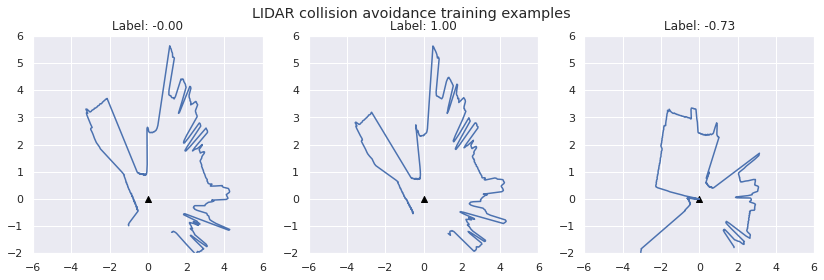

In [ ]:
def plot_lidar(lidar,ax):
  # Helper function for plotting polar-based lidar data
  angles = np.linspace(-2.35,2.35,len(lidar))
  x = lidar*np.cos(angles)
  y = lidar*np.sin(angles)
  ax.plot(y,x)
  ax.scatter([0],[0],marker="^",color="black")
  ax.set_xlim((-6,6))
  ax.set_ylim((-2,6))


sns.set()
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))
plot_lidar(x_train[0,0,:,0],ax1)
plot_lidar(x_train[0,12,:,0],ax2)
plot_lidar(x_train[9,0,:,0],ax3)
ax1.set_title("Label: {:0.2f}".format(y_train[0,0,0]))
ax2.set_title("Label: {:0.2f}".format(y_train[0,12,0]))
ax3.set_title("Label: {:0.2f}".format(y_train[9,0,0]))
fig.suptitle("LIDAR collision avoidance training examples")
fig.show()

## Bulding a stacked-NCP model

Here, we will create a neural network consisting of a feed-forward followed by a recurrent sub-model:

![wirings.png](https://github.com/mlech26l/keras-ncp/blob/master/misc/ncp_cnn.png?raw=true)

The input data are provided as a time-series where at each time-step we observe a full laser rangefinder scan. The network then feeds the LIDAR scan through the feedforward part to obtain a 32-dimensional latent representation of the current input. The recurrent NCP then takes this latant feature as input and updates its internal state and output prediction.


In [ ]:
N = x_train.shape[2]
channels = x_train.shape[3]

wiring = AutoNCP(21,1)

# We need to use the TimeDistributed layer to independently apply the
# Conv1D/MaxPool1D/Dense over each time-step of the input time-series.
model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, N, channels)),
        keras.layers.TimeDistributed(
            keras.layers.Conv1D(18, 5, strides=3, activation="relu")
        ),
        keras.layers.TimeDistributed(
            keras.layers.Conv1D(20, 5, strides=2, activation="relu")
        ),
        keras.layers.TimeDistributed(keras.layers.MaxPool1D()),
        keras.layers.TimeDistributed(
            keras.layers.Conv1D(22, 5, activation="relu")
        ),
        keras.layers.TimeDistributed(keras.layers.MaxPool1D()),
        keras.layers.TimeDistributed(
            keras.layers.Conv1D(24, 5, activation="relu")
        ),
        keras.layers.TimeDistributed(keras.layers.Flatten()),
        keras.layers.TimeDistributed(keras.layers.Dense(32, activation="relu")),
        LTC(wiring, return_sequences=True),
    ]
)
model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss="mean_squared_error",
)

model.summary(line_length=100)

Model: "sequential"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 time_distributed (TimeDistributed)          (None, None, 179, 18)                   108            
                                                                                                    
 time_distributed_1 (TimeDistributed)        (None, None, 88, 20)                    1820           
                                                                                                    
 time_distributed_2 (TimeDistributed)        (None, None, 44, 20)                    0              
                                                                                                    
 time_distributed_3 (TimeDistributed)        (None, None, 40, 22)                    2222           
                                                                       

Let's draw the NCP wiring of our model

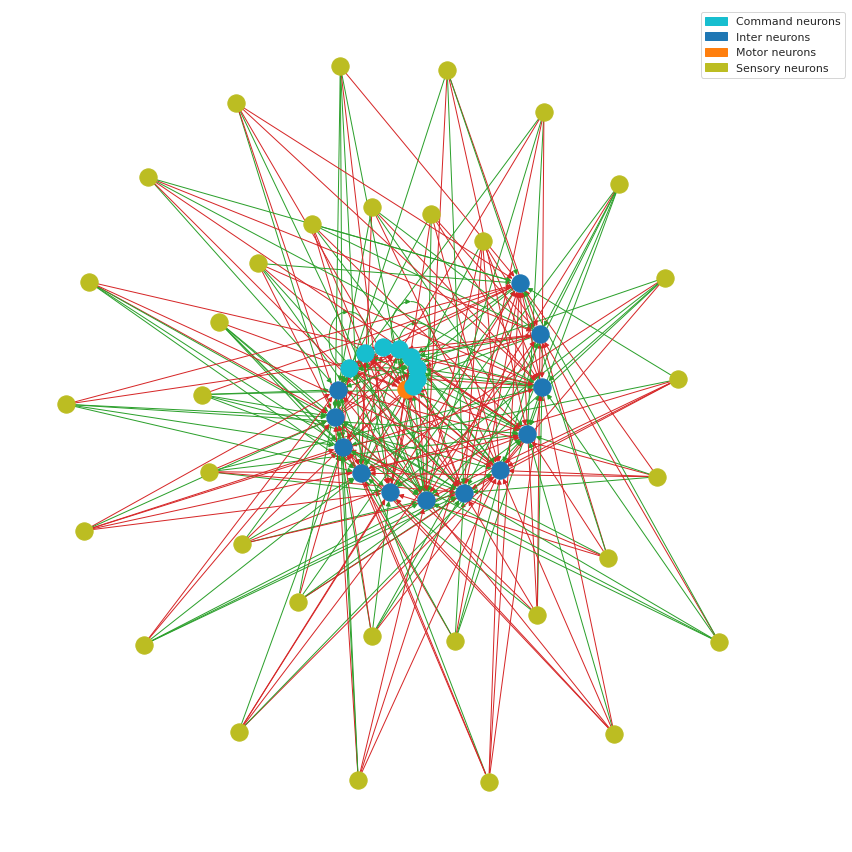

In [ ]:
sns.set_style("white")
plt.figure(figsize=(12, 12))
legend_handles = wiring.draw_graph(layout='spiral',neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

## Training the stacked-NCP model

Before training the model, we first evaluate how well it performs on the validation set

In [ ]:
model.evaluate(x_valid, y_valid)

8/8 [==============================] - 2s 116ms/step - loss: 0.2202


0.22022977471351624

In [ ]:
model.fit(
    x=x_train, y=y_train, batch_size=32, epochs=20, validation_data=(x_valid, y_valid)
)

Epoch 1/20
22/22 [==============================] - 19s 357ms/step - loss: 0.2091 - val_loss: 0.1778
Epoch 2/20
22/22 [==============================] - 8s 355ms/step - loss: 0.2012 - val_loss: 0.1681
Epoch 3/20
22/22 [==============================] - 8s 353ms/step - loss: 0.1837 - val_loss: 0.1827
Epoch 4/20
22/22 [==============================] - 8s 369ms/step - loss: 0.1673 - val_loss: 0.1432
Epoch 5/20
22/22 [==============================] - 8s 377ms/step - loss: 0.1492 - val_loss: 0.1183
Epoch 6/20
22/22 [==============================] - 8s 370ms/step - loss: 0.1395 - val_loss: 0.1162
Epoch 7/20
22/22 [==============================] - 8s 357ms/step - loss: 0.1342 - val_loss: 0.1109
Epoch 8/20
22/22 [==============================] - 10s 464ms/step - loss: 0.1279 - val_loss: 0.1207
Epoch 9/20
22/22 [==============================] - 8s 381ms/step - loss: 0.1256 - val_loss: 0.1056
Epoch 10/20
22/22 [==============================] - 8s 348ms/step - loss: 0.1262 - val_loss: 0.10

Now let's evaluate the performance of our model on the validation set after the training

In [ ]:
model.evaluate(x_valid, y_valid)

8/8 [==============================] - 1s 112ms/step - loss: 0.1183


0.11833970993757248